# The Data Science and ML Exercise for Movies on Bechdel Test

Uncomment below if you are running the notebook for the 1st time in a differnt Kernal

In [1]:
#!pip install pandas
#!pip install seaborn
#!pip install statsmodels
#!pip install scikit-learn

Import block for the libraries

In [30]:
import pandas as pd
import datetime as dt
import re
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

Loading the raw Bechdel data set and getting the mean rating for the year.

In [3]:
url_bechdel = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-03-09/raw_bechdel.csv'
raw_bechdel = pd.read_csv(url_bechdel,index_col='year',parse_dates=['year'])
raw_bechdel.reset_index(inplace=True)
year=raw_bechdel[raw_bechdel.columns[0]]

meanData = raw_bechdel.groupby('year', as_index=False)['rating'].mean()
raw_bechdel['year'] = [d.year for d in raw_bechdel.year]
years = raw_bechdel['year'].unique()

Data quality analysis for the raw data set

In [4]:
data_types = pd.DataFrame(raw_bechdel.dtypes,columns=['Data Type'])
missing_data = pd.DataFrame(raw_bechdel.isnull().sum(),columns=['Missing Values'])
unique_values = pd.DataFrame(columns=['Unique Values'])
for row in list(raw_bechdel.columns.values):
    unique_values.loc[row] = [raw_bechdel[row].nunique()]
dq_report = data_types.join(missing_data).join(unique_values)
print(dq_report)

        Data Type  Missing Values Unique Values
year        int64               0           128
id          int64               0          8839
imdb_id   float64               4          8828
title      object               0          8628
rating      int64               0             4


Creating a scater plot to indetify the trend of the data set against the year

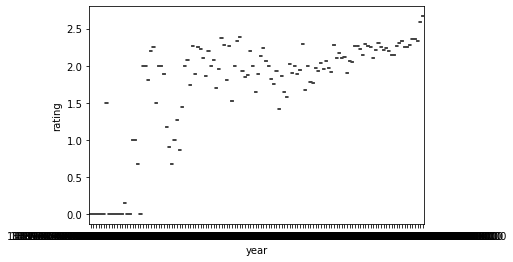

In [5]:
sns.boxplot(x='year', y='rating', data=meanData)
plt.show()

Linear plot to analyse the trend of the rating yearly.

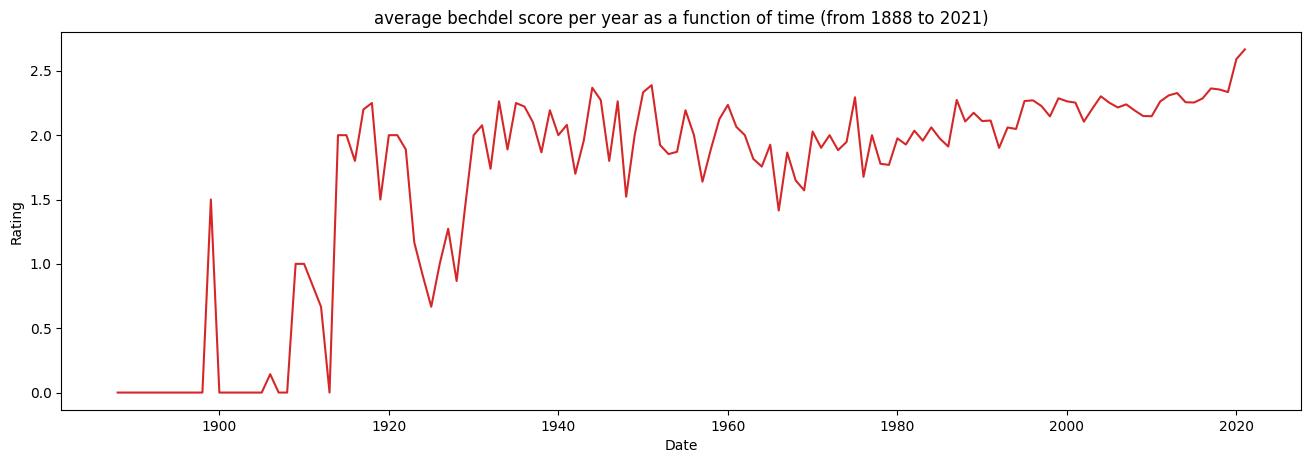

In [6]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Rating', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(meanData, x=meanData.year, y=meanData.rating, title='average bechdel score per year as a function of time (from 1888 to 2021)')    


Box plot for percentage of movies againts the decade and different scores that they got for the Bechdel test.

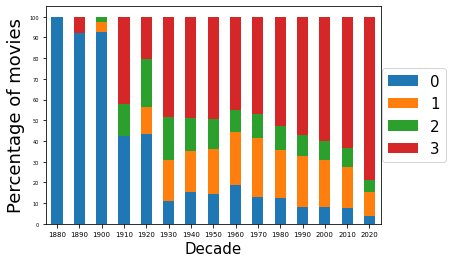

In [7]:
df_rating_ct = pd.crosstab(raw_bechdel.year,raw_bechdel.rating)

# http://stackoverflow.com/questions/17764619/pandas-dataframe-group-year-index-by-decade
# http://stackoverflow.com/questions/21247203/how-to-make-a-pandas-crosstab-with-percentages
# http://stackoverflow.com/questions/9938130/plotting-stacked-barplots-on-a-panda-data-frame

df_rating_ct.groupby((df_rating_ct.index//10)*10).sum().apply(lambda x: x/x.sum(),axis=1).plot(kind='bar',stacked=True)
#print(df_rating_ct)
# Fix up the plot
plt.ylabel('Percentage of movies',fontsize=18)
plt.yticks(np.arange(0,1.1,.10),np.arange(0,110,10),fontsize=5)
plt.xlabel('Decade',fontsize=15)
plt.xticks(rotation=0,fontsize=7)
plt.legend(loc='center',bbox_to_anchor=(1.1,.5),fontsize=15)

To forecast future changes in the average Bachdel Score over time We can estimate a statistical model. The observation is a general upward trend in movies passing more of the Bechdel test.The scores are as follows. 

3 - Passed the test
2 - Only 2 points are true
1 - only 1 point is true
0 - Fewer women 

Text(0, 0.5, 'Avg. Bechdel Test')

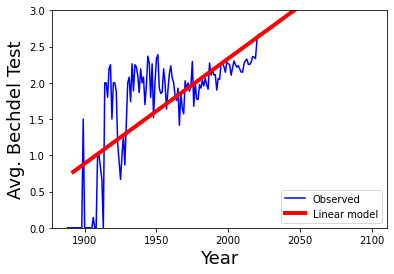

In [8]:
avg_bechdel = raw_bechdel.groupby(year)['rating'].agg(np.mean)
avg_bechdel.index.name = 'date'

avg_bechdel.name = 'bechdel'
avg_bechdel = avg_bechdel.reset_index()

# convert Timestamp categorical variable to numeric (year)
avg_bechdel['date'] = avg_bechdel['date'].apply(lambda x: x.year)

# extrapolate 100 datapoints upto 2100
X = pd.DataFrame({"date": np.linspace(start=1892,stop=2100.,num=100)})

l_model = smf.ols(formula='bechdel ~ date', data=avg_bechdel).fit()
#print(l_model.summary())

# plot actual data
plt.plot(avg_bechdel['date'],avg_bechdel['bechdel'],c='b',label='Observed')

#Plot prediction line using model
plt.plot(X,l_model.predict(X),c='r',label='Linear model',lw=4)

plt.legend(loc='lower right')
plt.ylim((0,3))
#plt.xlim((1988,2100))
plt.xlabel('Year')
plt.ylabel('Avg. Bechdel Test')
plt.xlabel('Year',fontsize=18)
plt.ylabel('Avg. Bechdel Test',fontsize=18)


Using the slope of the Linear model 𝑦=m𝑥+c equation to solve for 𝑦=2 : 𝑥=(𝑦−c)/m , or to find the date where average movies starts to have a BS of 2

Then convert the float into a proper date and return the day of the week as well (Mondays are 0)

In [9]:
import datetime
year_est = (2 - l_model.params['Intercept'])/l_model.params['date']

year_int = int(year_est)

d = datetime.timedelta(days=(year_est - year_int)*365.25)

day_one = datetime.datetime(year_int,1,1)

date = d + day_one

print(date, date.weekday())

2045-11-14 06:42:01.198603 1


According to the above analysis, In 2045, 50% of films will alteast gain 2 points in the Bechdel Test.

Below block is to load the movie data set and where some data cleancing has been done

In [10]:
data_file = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-03-09/movies.csv'
data = pd.read_csv(data_file,sep=',')
data_types = pd.DataFrame(data.dtypes,columns=['Data Type'])
missing_data = pd.DataFrame(data.isnull().sum(),columns=['Missing Values'])
unique_values = pd.DataFrame(columns=['Unique Values'])
for row in list(data.columns.values):
    unique_values.loc[row] = [data[row].nunique()]
dq_report = data_types.join(missing_data).join(unique_values)
print(dq_report)

              Data Type  Missing Values Unique Values
year              int64               0            44
imdb             object               0          1794
title            object               0          1768
test             object               0            10
clean_test       object               0             5
binary           object               0             2
budget            int64               0           272
domgross        float64              17          1750
intgross        float64              11          1756
code             object               0            85
budget_2013       int64               0          1188
domgross_2013   float64              18          1775
intgross_2013   float64              11          1782
period_code     float64             179             5
decade_code     float64             179             3
imdb_id           int64               0          1794
plot             object             202          1592
rated            object     

More data clansing

In [11]:
# Blank out non-MPAA or minor ratings (NC-17, X)
data.rated= data.rated.replace(to_replace=['N/A','Not Rated','Approved','Unrated','TV-PG','TV-G','TV-14','TV-MA','NC-17','X'],value=np.nan)

# Take the imdbVotes formatted as string containing "N/A" and comma-delimited thousands, convert to float
data.imdb_votes = data.imdb_votes.dropna().replace('N/A',np.nan).dropna().apply(lambda x:float(x.replace(',','')))

# Take the Metascore formatted as string containing "N/A", convert to float
# Also divide by 10 to make effect sizes more comparable
data.metascore = data.metascore.dropna().apply(float)/10.


# Take the imdbRating formatted as string containing "N/A", convert to float
data.imdb_rating = data.imdb_rating.dropna().apply(float)

# Convert imdb_ID to int, set it as the index
data.imdb_id = data.imdb_id.dropna().apply(int)
data = data.set_index('imdb_id')

Checking the data quality of movies data set

In [12]:
data_types = pd.DataFrame(data.dtypes,columns=['Data Type'])
missing_data = pd.DataFrame(data.isnull().sum(),columns=['Missing Values'])
unique_values = pd.DataFrame(columns=['Unique Values'])
for row in list(data.columns.values):
    unique_values.loc[row] = [data[row].nunique()]
dq_report = data_types.join(missing_data).join(unique_values)
print(dq_report)

              Data Type  Missing Values Unique Values
year              int64               0            44
imdb             object               0          1794
title            object               0          1768
test             object               0            10
clean_test       object               0             5
binary           object               0             2
budget            int64               0           272
domgross        float64              17          1750
intgross        float64              11          1756
code             object               0            85
budget_2013       int64               0          1188
domgross_2013   float64              18          1775
intgross_2013   float64              11          1782
period_code     float64             179             5
decade_code     float64             179             3
plot             object             202          1592
rated            object             245             4
response         object     

Merging the Movies and raw data using inner join

In [13]:
df=pd.merge(data,raw_bechdel,on=['title','year'],how='inner',indicator=True)

Text(0, 0.5, '')

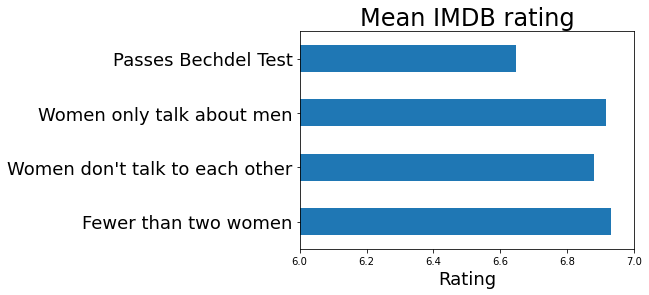

In [14]:
# Make the bar-plot
df['imdb_rating'].groupby(df['rating']).agg(np.mean).plot(kind='barh')
plt.yticks(plt.yticks()[0],["Fewer than two women",
                             "Women don't talk to each other",
                             'Women only talk about men',
                             'Passes Bechdel Test'
                             ],fontsize=18)
plt.xlabel('Rating',fontsize=18)
plt.title('Mean IMDB rating',fontsize=24)
plt.xlim((6,7))
plt.ylabel('')

We can see that based on my analysis when the Bechdel score is high, movies get a low rating on IMDB.
Below we are checking the data quality of the merged dataset.

In [15]:
data_types = pd.DataFrame(df.dtypes,columns=['Data Type'])
missing_data = pd.DataFrame(df.isnull().sum(),columns=['Missing Values'])
unique_values = pd.DataFrame(columns=['Unique Values'])
for row in list(df.columns.values):
    unique_values.loc[row] = [df[row].nunique()]
dq_report = data_types.join(missing_data).join(unique_values)
print(dq_report)

              Data Type  Missing Values Unique Values
year              int64               0            44
imdb             object               0          1727
title            object               0          1701
test             object               0            10
clean_test       object               0             5
binary           object               0             2
budget            int64               0           268
domgross        float64              17          1683
intgross        float64              11          1689
code             object               0            85
budget_2013       int64               0          1155
domgross_2013   float64              18          1708
intgross_2013   float64              11          1715
period_code     float64             172             5
decade_code     float64             172             3
plot             object             135          1592
rated            object             178             4
response         object     

In [16]:
model_building = df

More data cleansing on merged dataset to prepare the ML model

In [17]:
model_building['US_REGION'] = model_building['country'].str.contains('USA')
#print(model_building['country'].str.contains('USA').fillna(False,inplace=True))
model_building['US_REGION'] = model_building['US_REGION'].astype(bool).astype(int)
model_building['imdb_rating'] = model_building['imdb_rating'].fillna(0)
model_building['imdb_votes'] = model_building['imdb_votes'].fillna(0)
#print(model_building)

Checking the data quality after cleansing the data

In [18]:
data_types = pd.DataFrame(model_building.dtypes,columns=['Data Type'])
missing_data = pd.DataFrame(model_building.isnull().sum(),columns=['Missing Values'])
unique_values = pd.DataFrame(columns=['Unique Values'])
for row in list(df.columns.values):
    unique_values.loc[row] = [df[row].nunique()]
dq_report = data_types.join(missing_data).join(unique_values)
print(dq_report)

              Data Type  Missing Values Unique Values
year              int64               0            44
imdb             object               0          1727
title            object               0          1701
test             object               0            10
clean_test       object               0             5
binary           object               0             2
budget            int64               0           268
domgross        float64              17          1683
intgross        float64              11          1689
code             object               0            85
budget_2013       int64               0          1155
domgross_2013   float64              18          1708
intgross_2013   float64              11          1715
period_code     float64             172             5
decade_code     float64             172             3
plot             object             135          1592
rated            object             178             4
response         object     

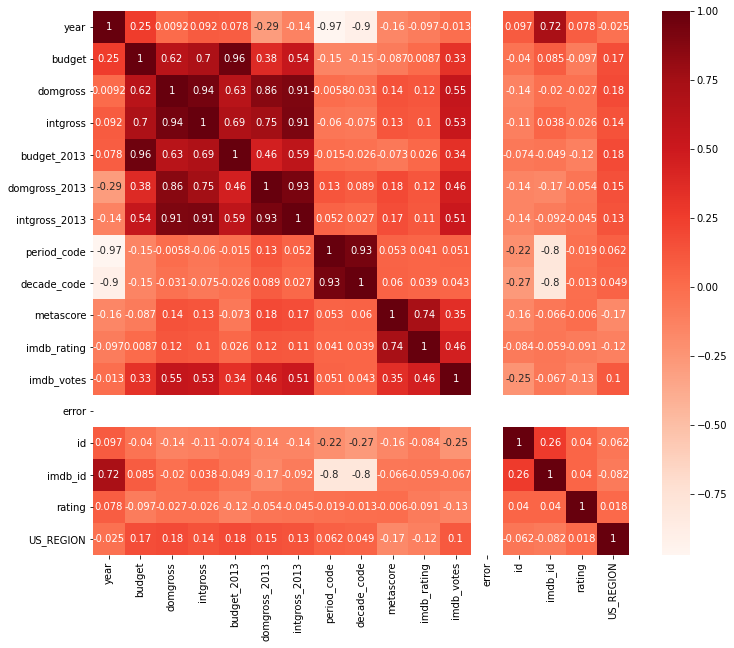

year             0.077928
budget           0.097457
domgross         0.027410
intgross         0.026216
budget_2013      0.120036
domgross_2013    0.054077
intgross_2013    0.045335
period_code      0.018821
decade_code      0.013471
imdb_rating      0.091288
imdb_votes       0.134088
id               0.040100
imdb_id          0.040385
rating           1.000000
US_REGION        0.018266
Name: rating, dtype: float64


In [19]:
# use only numeric columns for linear regression analysis
# numeric columns are used so that we can apply correlation coefficient for feature selection
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = model_building.select_dtypes(include=numerics)

# Pearson correlation heatmap to test correlation between independent variables and dependent variable
cor = numeric_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# select features with a correlation coefficient greater than 0.01
cor_target = abs(cor["rating"])
relevant_features = cor_target[cor_target>0.01]
print(relevant_features)

We can see that there isn't much columns to use as good features on the pearson output. Hence I have taken the numeric and not null data to run the linear reggression model. 

In [20]:
ML_DF = numeric_df.filter(['year','imdb_rating','imdb_votes','US_REGION'], axis=1)
ML_DF=ML_DF.loc[(numeric_df!=0).any(axis=1)]
#print(ML_DF)

In [21]:
# drop NAN values
numeric_df = numeric_df.dropna(subset = ['US_REGION', 'imdb_rating', 'imdb_votes'])
numeric_df=numeric_df.loc[(numeric_df!=0).any(axis=1)]
# train linear regression model using selected features
indX = numeric_df[["US_REGION", "imdb_rating", "imdb_votes"]]
depY =numeric_df["rating"]

lm = linear_model.LinearRegression()

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(indX, depY, test_size=0.33, random_state=1)

# train model
model = lm.fit(X_train,y_train)

# evaluate the model
y_pred = model.predict(X_test)

# evaluate predictions
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

# R^2 score of model
print('R^2: %.3f' % lm.score(X_test,y_test))

# intercept
print('intercept: %.3f' % lm.intercept_)

MAE: 0.944
R^2: 0.007
intercept: 2.120


In [ ]:
Since the R squared value is very low we cant use this model

In [25]:
y = depY
x = indX
x.head()

,US_REGION,imdb_rating,imdb_votes
0,1,0.0,0.0
1,1,0.0,0.0
2,1,8.3,143446.0
3,1,6.8,87301.0
4,1,7.6,43608.0


Applying the Logistic Regression to the data

In [28]:
scorer = make_scorer(accuracy_score, greater_is_better = True)

cv = StratifiedKFold(n_splits=5,shuffle=True)

# Let's try 3 different parameters within the logistic model
print( cross_val_score(LogisticRegression(class_weight='balanced'), x,y, cv=cv, scoring=scorer).mean())
print( cross_val_score(LogisticRegression(C=100), x,y, cv=cv, scoring=scorer).mean())
print( cross_val_score(LogisticRegression(), x,y, cv=cv, scoring=scorer).mean())
print( cross_val_score(LogisticRegression(class_weight='balanced',C=100), x,y, cv=cv, scoring=scorer).mean())

0.2715087542933735
0.5495132780430594
0.5489302169724386
0.19453799112004694


we can see the scores of this mode is about 50% fine hence using this model to predict

In [31]:
logmodel_balanced = LogisticRegression(class_weight='balanced').fit(X_train,y_train)
logmodel_C100 = LogisticRegression(C=100).fit(X_train,y_train)
logmodel_default = LogisticRegression().fit(X_train,y_train)
logmodel_balanced_C100 = LogisticRegression(class_weight='balanced',C=100).fit(X_train,y_train)

predictions_balanced = logmodel_balanced.predict(X_test)
predictions_C100 = logmodel_C100.predict(X_test)
predictions_default = logmodel_default.predict(X_test)
predicitons_balanced_C100 = logmodel_balanced_C100.predict(X_test)

print(classification_report(y_test, predictions_balanced))
print(classification_report(y_test, predictions_C100))
print(classification_report(y_test, predictions_default))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.31      0.94      0.46       173
           2       0.00      0.00      0.00        61
           3       0.60      0.09      0.15       295

    accuracy                           0.33       570
   macro avg       0.23      0.26      0.15       570
weighted avg       0.41      0.33      0.22       570

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.00      0.00      0.00       173
           2       0.00      0.00      0.00        61
           3       0.52      1.00      0.68       295

    accuracy                           0.52       570
   macro avg       0.13      0.25      0.17       570
weighted avg       0.27      0.52      0.35       570

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.

C:\Users\malsh\anaconda3\envs\NewRStudio\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\malsh\anaconda3\envs\NewRStudio\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\malsh\anaconda3\envs\NewRStudio\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\User

In [32]:
# Re-fit the Logistic Regression model on all the data
logmodel_balanced_C100 = LogisticRegression(class_weight='balanced',C=100).fit(x,y)

In [39]:
# ML_DF dataset is the one with everything except bechdel scores

model_application = ML_DF

to_drop = ['imdb_votes']
prediction_data = model_application.drop(to_drop, axis=1)
IMDb_predictions = logmodel_balanced_C100.predict(prediction_data)
print(model_application)

      year  imdb_rating  imdb_votes  US_REGION
0     2013          0.0         0.0          1
1     2012          0.0         0.0          1
2     2013          8.3    143446.0          1
3     2013          6.8     87301.0          1
4     2013          7.6     43608.0          1
...    ...          ...         ...        ...
1722  1971          6.6     10275.0          1
1723  1971          7.6     37726.0          1
1724  1971          7.8     62153.0          1
1725  1971          0.0         0.0          1
1726  1970          6.2      6462.0          1

[1727 rows x 4 columns]


In [40]:
IMDb_Bechdel_predictions = pd.DataFrame({'year': model_application['year'],
                                         'Bechdel_Predictions': IMDb_predictions})
print(IMDb_Bechdel_predictions)

      year  Bechdel_Predictions
0     2013                    1
1     2012                    1
2     2013                    1
3     2013                    1
4     2013                    1
...    ...                  ...
1722  1971                    1
1723  1971                    1
1724  1971                    1
1725  1971                    1
1726  1970                    1

[1727 rows x 2 columns]


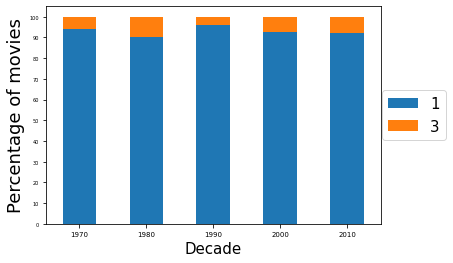

In [41]:
df_rating_ct = pd.crosstab(IMDb_Bechdel_predictions.year,IMDb_Bechdel_predictions.Bechdel_Predictions)

# http://stackoverflow.com/questions/17764619/pandas-dataframe-group-year-index-by-decade
# http://stackoverflow.com/questions/21247203/how-to-make-a-pandas-crosstab-with-percentages
# http://stackoverflow.com/questions/9938130/plotting-stacked-barplots-on-a-panda-data-frame

df_rating_ct.groupby((df_rating_ct.index//10)*10).sum().apply(lambda x: x/x.sum(),axis=1).plot(kind='bar',stacked=True)
#print(df_rating_ct)
# Fix up the plot
plt.ylabel('Percentage of movies',fontsize=18)
plt.yticks(np.arange(0,1.1,.10),np.arange(0,110,10),fontsize=5)
plt.xlabel('Decade',fontsize=15)
plt.xticks(rotation=0,fontsize=7)
plt.legend(loc='center',bbox_to_anchor=(1.1,.5),fontsize=15)

Q1. Provide your personal objective assessment of the model (accuracy,
performance, …).
Personally I need to do more cleansing on the data set to get more accurate results as we can see the predicted score is not according to the actual trend.
Q2. What would you do to improve the model?
I would try more ML models to see the best score and use that